In [ ]:
# Установим gym
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.2 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Создадим переменные окружения
env = gym.make("Taxi-v3")
observation, info = env.reset()

In [ ]:
# Создадим класс агента по примеру из документации gym
class TaxiAgent:
    def __init__(
            self,
            learning_rate: float,
            initial_epsilon: float,
            epsilon_decay: float,
            final_epsilon: float,
            discount_factor: float = 0.95,
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: int) -> int:
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
            self,
            obs: int,
            action: int,
            reward: int,
            terminated: bool,
            next_obs: int,
    ):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
                reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
                self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)


Обучим агента.

In [ ]:
# Параметры обучения агента
learning_rate = 0.01
n_episodes = 10_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = TaxiAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Тренируем агента
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Проигрываем эпизод
    reward_episode = 0
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Обновляем агента
        agent.update(obs, action, reward, terminated, next_obs)
        reward_episode += reward

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

env.close()

100%|██████████| 10000/10000 [01:23<00:00, 120.23it/s]


Визуализируем результаты обучения.

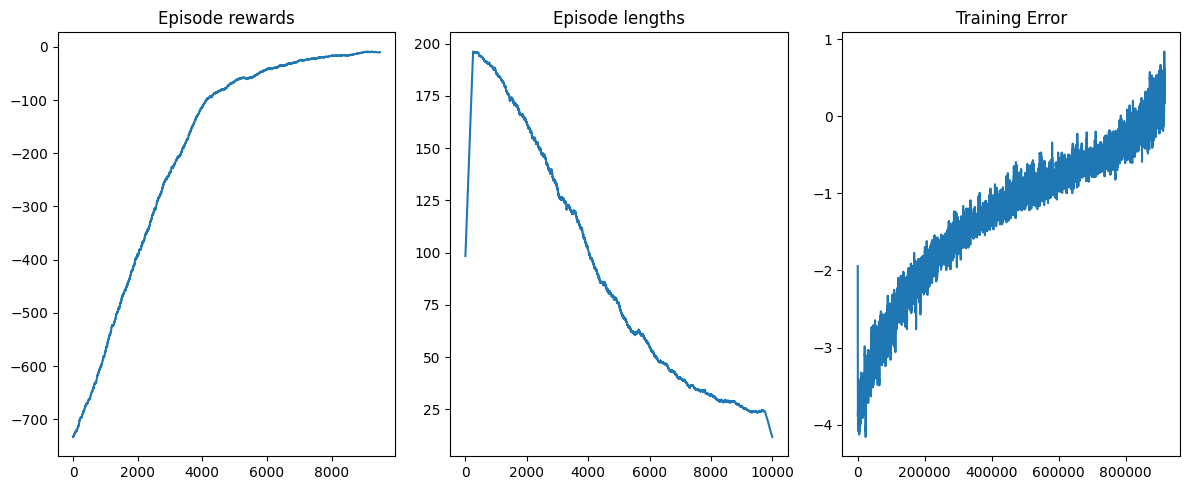

In [ ]:
import matplotlib.pyplot as plt
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")

# Вычислим скользящее среднее для получения более сглаженного графика
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    ) / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    ) / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
# Проверяем эффективность обученного агента на случайной среде
n_test_episodes = 100

rewards = np.zeros(n_test_episodes)

for episode in tqdm(range(n_test_episodes)):
    env = gym.make("Taxi-v3")
    obs, info = env.reset()
    done = False

    reward_episode = 0
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)
        reward_episode += reward

        done = terminated or truncated
        obs = next_obs

    rewards[episode - 1] = reward_episode

env.close()

100%|██████████| 100/100 [00:01<00:00, 94.37it/s]


Посмотрим на результаты.

In [ ]:
print('Cредняя награда за эпизод: {}'.format(np.mean(rewards)))
print('Стандартное отклонение: {}'.format(np.std(rewards)))

Cредняя награда за эпизод: -8.93
Стандартное отклонение: 20.762588952247743
